In [1]:
from read_mcts_trace import load_trace_log, find_sole_log, filter_to_latest_search
from mcts_analysis import array_index_top_k

import matplotlib.pyplot as plt

In [2]:
logs = filter_to_latest_search(load_trace_log("/tmp/alphablokus_trace"))

In [3]:
started_search = find_sole_log(logs, lambda t: t.type == "started_search")
search_root_id = started_search.root_node_id
created_root_node = find_sole_log(logs, lambda t: t.type == "created_node" and t.node_id == search_root_id)
selected_move_to_play = find_sole_log(logs, lambda t: t.type == "selected_move_to_play")
selected_move_by_ucb = [log for log in logs if log.type == "selected_move_by_ucb"][-1]
root_network_eval_result = find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == search_root_id)

In [ ]:
# Based on final visit counts
array_index_top_k(selected_move_by_ucb.children_visit_counts, created_root_node.array_index_to_move_index)

# Interesting ones:
# 22532 - i picked it
# 5554 - good
# 6223 - good

[(267, 22532, 72),
 (103, 6223, 33),
 (88, 5554, 18),
 (268, 22617, 18),
 (239, 21593, 17),
 (56, 2994, 12),
 (399, 26847, 12),
 (351, 25464, 10),
 (78, 5157, 5),
 (266, 22516, 3)]

In [5]:
# Based on policy
array_index_top_k(selected_move_by_ucb.children_prior_probabilities, created_root_node.array_index_to_move_index)

[(239, 21593, 0.08969379),
 (268, 22617, 0.07366694),
 (267, 22532, 0.040938765),
 (88, 5554, 0.04070883),
 (351, 25464, 0.03652385),
 (399, 26847, 0.035498593),
 (103, 6223, 0.029299868),
 (56, 2994, 0.024358327),
 (78, 5157, 0.019180005),
 (266, 22516, 0.01833523)]

In [22]:
print("Root value: ", root_network_eval_result.value)

Root value:  [0.25184193, 0.56797826, 0.1432931, 0.036886718]


In [21]:
child = find_sole_log(logs, lambda t: t.type == "added_child" and t.parent_node_id == search_root_id and t.move_index == 5554).child_node_id
print("Child value: ", find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == child).value)

children = set([child])
while True:
    children_last_cycle = len(children)
    for log in logs:
        if log.type == "added_child" and log.parent_node_id in children:
            children.add(log.child_node_id)
    if len(children) == children_last_cycle:
        break


values = []
for child in children:
    child_node = find_sole_log(logs, lambda t: t.type == "network_eval_result" and t.node_id == child)
    values.append(child_node.value[0])

sum(values) / len(values)

Child value:  [0.0829857, 0.3697102, 0.39437187, 0.15293227]


0.21055670766666668

In [24]:
best_prior_array_index = max(enumerate(selected_move_by_ucb.children_prior_probabilities), key=lambda x: x[1])[0]
best_prior_move_index = created_root_node.array_index_to_move_index[best_prior_array_index]

print("Best prior array index: ", best_prior_array_index)
print("Best prior move index: ", best_prior_move_index)

Best prior array index:  239
Best prior move index:  21593


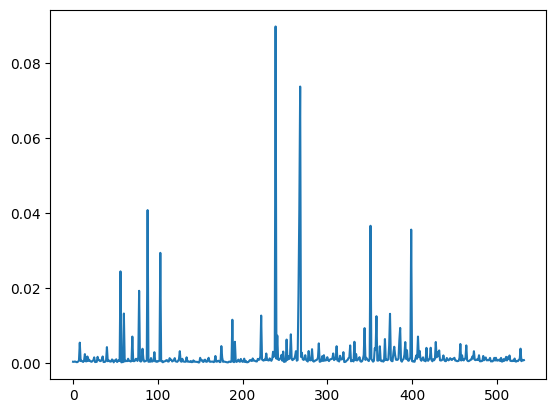

In [17]:
plt.plot(selected_move_by_ucb.children_prior_probabilities)
# plt.plot(root_network_eval_result.policy)
# plt.plot(selected_move_to_play.children_visit_counts)